# Cholera

In [1]:

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
import itertools
import numpy as onp

import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2023-12-11 04:30:29.818165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('data/dacca/covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('data/dacca/covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(onp.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)#[20:]
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**(-3)), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 17.3, 0.057, 0, 9.8, onp.exp(-4.8), 0.999999, (-5.0*10**(-3)), 3.2, 0.25, np.array([1.2,6.2,-3.4,3.9,3.2,4.3]), 3, 0.02


gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = np.array(1)
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = onp.exp(-4.5)
omegas = np.log(np.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))


theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

In [3]:
pfilter(theta, ys, 10000, covars, thresh=-1)

Array(3749.0396, dtype=float32)

In [3]:
n_trials = 100
J = 10000

def get_rand_theta():
    return transform_thetas(onp.random.uniform(10.00, 40.00),
                onp.random.uniform(0.03, 0.60), 
                         rho, 
                 onp.random.uniform(0.20, 30.00), 
                         omega, 
                         c, 
                 onp.random.uniform(-1.00, 0.00)*0.01, 
                 onp.random.uniform(1.00, 5.00), 
                 onp.random.uniform(0.10, 0.50), 
                 onp.random.uniform(0,8,size=6)+np.array([-4,0,-4,0,0,0]), 
                 onp.random.uniform(-10,0,size=6))

def get_rand_theta(J=J):
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    rands = onp.array(onp.repeat(((lows+highs)/2)[None,:], J, axis=0)).T
    rands[~onp.isinf(lows)] = onp.random.uniform(lows[~onp.isinf(lows)], 
                       highs[~onp.isinf(highs)],
                       size=(J, len(highs[~onp.isinf(highs)]))).T
    return rands.T
                       
                       


sigmas = (np.abs(theta)/600)
theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) #6 for close to maxima
#theta_ests = get_rand_theta(J).mean(0)

'''
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)


newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)

'''
print(pfilter(theta_ests, ys, J, covars, thresh=-1))
#res = minimize(pfilter, x0=theta_ests, args=(ys, J, covars, 0), method='BFGS', options={'maxiter': 10})
get_thetas(theta_ests)

# try cross-comparison, fig 2 in pnas, on close to MLE
# use if2 settings

3840.0928


(Array(15.079871, dtype=float32),
 Array(0.04946967, dtype=float32),
 Array(0., dtype=float32),
 Array(36.460865, dtype=float32),
 Array(0.01433833, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.00598649, dtype=float32),
 Array(2.8638976, dtype=float32),
 Array(0.24290162, dtype=float32),
 Array([ 0.73597187,  6.293639  , -3.1178217 ,  3.9003925 ,  3.4865851 ,
         4.318408  ], dtype=float32),
 Array([-1.7164558, -2.4591317, -2.8705957, -4.5521607, -8.0660715,
        -4.1617336], dtype=float32),
 3,
 0.02)

In [7]:
dpf_grads = [jgrad(theta, 
                   ys, J, covars, -1, jax.random.PRNGKey(i))
             for i in tqdm(range(100))]

pf_grads = [jgrad_pf(theta, 
                   ys, J, covars, -1, jax.random.PRNGKey(i))
             for i in tqdm(range(100))]

100%|██████████| 100/100 [07:57<00:00,  4.77s/it]


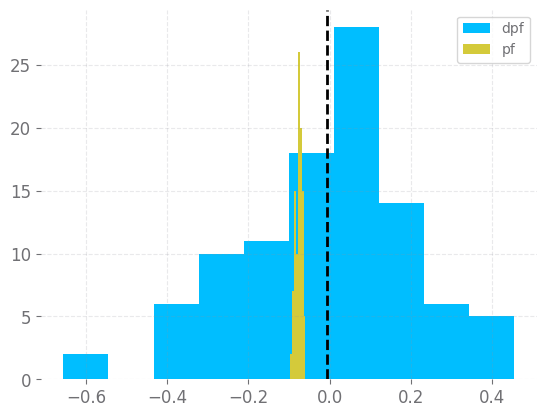

In [33]:
col = 6
norm_dpf = np.array(dpf_grads)/np.linalg.norm(np.array(dpf_grads), axis=1)[:,None]
norm_pf = np.array(pf_grads)/np.linalg.norm(np.array(pf_grads), axis=1)[:,None]
#norm_dpf = np.array(dpf_grads)
#norm_pf = np.array(pf_grads)
plt.hist(norm_dpf[:,col], label='dpf', bins='auto')
plt.axvline(norm_dpf[:,col].mean(), color='black', linestyle='--')
plt.hist(norm_pf[:,col], label='pf', bins='auto')
plt.legend()
plt.show()

100%|██████████| 50/50 [00:20<00:00,  2.50it/s]


(array([29.,  8.,  6.,  4.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([3778.68652344, 4073.30566406, 4367.92480469, 4662.54394531,
        4957.16308594, 5251.78222656, 5546.40185547, 5841.02099609,
        6135.64013672, 6430.25927734, 6724.87841797]),
 <BarContainer object of 10 artists>)

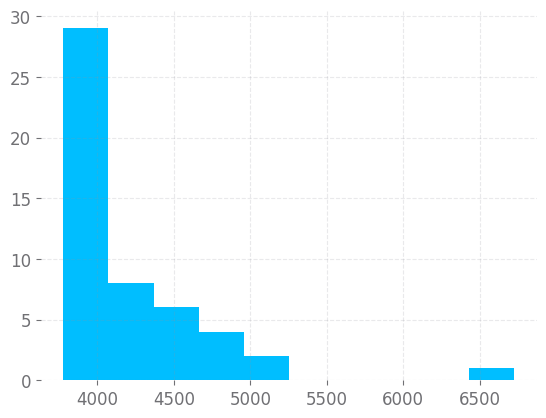

In [62]:
perturbs = [pfilter(theta + 60*sigmas*onp.random.normal(size=theta.shape), 
         ys, J, covars, -1) for i in tqdm(range(50))]
plt.hist(perturbs)

newt_logliks, newt_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=1e-1, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=100, method='Newton', scale=False, ls=True)

weighted_newt_logliks, weighted_newt_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=100, method='WeightedNewton', scale=False, ls=True)

In [ ]:
#make plot of runtime of backward pass vs number of particles and number of timesteps

#try adaptive swapping between IF2 and AD
#Benchmark local search when MLE found, for swapping to AD to be worth it

bfgs_logliks, bfgs_ests = train(theta_ests, ys, covars, beta=0.9*10, 
                                eta=np.flip(np.linspace(0.0001,0.2,40)), 
                                c=0.01, max_ls_itn=8, 
                            verbose=True, itns=40, J=J, thresh=0, method='BFGS', scale=True, ls=False)

mif_logliks, mif_params = mif(theta_ests, ys, sigmas=0.01*sigmas, 
                              sigmas_init = 60*sigmas, covars=covars, verbose=True,
                              M=40, J=J, a=0.99, monitor=True, thresh=-1)

gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.0001,0.2,40)), 
                            verbose=True, itns=40, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True)

mif_logliks, mif_params = mif(get_rand_theta(), ys, sigmas=0.02, 
                              sigmas_init = 1e-20, covars=covars, verbose=True,
                              M=40, J=J, a=0.95, monitor=True, thresh=-1)

gd_logliks, gd_ests = train(mif_params[mif_logliks.argmin()].mean(0), ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.01,0.2,100)), 
                            verbose=True, itns=100, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True) #np.flip(np.linspace(0.0001,0.2,40) for nbhd

In [ ]:
n_trials = 100
J = 10000
close = False


#bbox = np.load('bbox.npy')

original_logliks = []
original_theta_ests = []
mif_logliks_trials = []
mif_params_trials = []
mif_logliks_warm_trials = []
mif_params_warm_trials = []
gd_logliks_trials = []
gd_ests_trials = []
gd_logliks_pf_trials = []
gd_ests_pf_trials = []
gd_logliks_raw_trials = []
gd_ests_raw_trials = []
gd_logliks_pf_raw_trials = []
gd_ests_pf_raw_trials = []


for trial in tqdm(range(n_trials)):
    
    if close:
        sigmas = (np.abs(theta)/600)
        theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) #6 for close to maxima
        orig_loglik = pfilter(theta_ests, ys, J, covars, thresh=-1)
        gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.0001,0.1,40)), 
                            verbose=False, itns=40, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True)
    else:
        bbox = get_rand_theta(1).squeeze()# np.array([get_rand_theta() for j in tqdm(range(J))])
        orig_loglik = pfilter(bbox, ys, J, covars, thresh=-1)
        mif_logliks_warm, mif_params_warm = mif(bbox, ys, sigmas=0.02, 
                                  sigmas_init = 1e-20, covars=covars, verbose=False,
                                  M=40, J=J, a=0.95, monitor=True, thresh=-1) 
        theta_ests = mif_params_warm[mif_logliks_warm.argmin()].mean(0)
        gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.1,0.15,60)), 
                            verbose=False, itns=60, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True) 
        gd_logliks_pf, gd_ests_pf = train_pf(theta_ests, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.1,0.15,60)), 
                            verbose=False, itns=60, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True) 
        #mif_logliks = mif_logliks_warm
        #mif_params = mif_params_warm
        
        mif_logliks, mif_params = mif(bbox, ys, sigmas=0.02, 
                                  sigmas_init = 1e-20, covars=covars, verbose=False,
                                  M=100, J=J, a=0.98, monitor=True, thresh=-1) #0.99
        
        
        gd_logliks_raw, gd_ests_raw = train(bbox, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.1,0.2,100)), 
                            verbose=False, itns=100, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True) 
        gd_logliks_pf_raw, gd_ests_pf_raw = train_pf(bbox, ys, covars, beta=0.9, 
                            eta=np.flip(np.linspace(0.1,0.2,100)), 
                            verbose=False, itns=100, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True) 
        

    #theta_ests = bbox[trial]
    #
    '''
    mif_logliks, mif_params = mif(theta_ests, ys, sigmas=0.01*sigmas, 
                              sigmas_init = 60*sigmas, covars=covars, verbose=False,
                              M=40, J=J, a=0.99, monitor=True, thresh=-1)
                              
    
    '''
    
    
    original_logliks.append(orig_loglik)
    original_theta_ests.append(theta_ests)
    
    
    outf = open('outs/trials'+str(trial)+'.txt', 'w')
    outf.write(str(trial) + 'orig ' + str(orig_loglik) + ' gd ' + str(gd_logliks[-1]) + ' , ' + str(min(gd_logliks)) + ' mif ' + str(mif_logliks[-1]) + ' , ' + str(min(mif_logliks)))
    
    print('orig', orig_loglik, 'gd', gd_logliks[-1], 'if2', mif_logliks[-1])
    
    mif_logliks_trials.append(mif_logliks)
    mif_params_trials.append(mif_params)
    
    mif_logliks_warm_trials.append(mif_logliks_warm)
    mif_params_warm_trials.append(mif_params_warm)
    
    gd_logliks_trials.append(gd_logliks)
    gd_ests_trials.append(gd_ests)
    
    
    gd_logliks_pf_trials.append(gd_logliks_pf)
    gd_ests_pf_trials.append(gd_ests_pf)
    
    gd_logliks_raw_trials.append(gd_logliks_raw)
    gd_ests_raw_trials.append(gd_ests_raw)
    
    
    gd_logliks_pf_raw_trials.append(gd_logliks_pf_raw)
    gd_ests_pf_raw_trials.append(gd_ests_pf_raw)
    
    

# try cross-comparison, fig 2 in pnas, on close to MLE
# use if2 settings

100%|██████████| 40/40 [00:44<00:00,  1.10s/it]

100%|██████████| 60/60 [07:21<00:00,  7.37s/it]

100%|██████████| 60/60 [06:47<00:00,  6.80s/it]

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]

100%|██████████| 100/100 [11:17<00:00,  6.77s/it]

  8%|▊         | 8/100 [00:54<10:22,  6.77s/it]

In [6]:
np.save('outs/mif_logliks_trials-3.npy', np.array(mif_logliks_trials))
np.save('outs/mif_logliks_warm_trials-3.npy', np.array(mif_logliks_warm_trials))
np.save('outs/gd_logliks_trials-3.npy', np.array(gd_logliks_trials))
np.save('outs/gd_logliks_pf_trials-3.npy', np.array(gd_logliks_pf_trials))
np.save('outs/gd_logliks_raw_trials-3.npy', np.array(gd_logliks_raw_trials))
np.save('outs/gd_logliks_pf_raw_trials-3.npy', np.array(gd_logliks_pf_raw_trials))

In [25]:
mif_logliks_trials = np.vstack([np.load('outs/mif_logliks_trials.npy'),
                               np.load('outs/mif_logliks_trials-1.npy'),
                               np.load('outs/mif_logliks_trials-2.npy')])

mif_logliks_warm_trials = np.vstack([np.load('outs/mif_logliks_warm_trials.npy'),
                                    np.load('outs/mif_logliks_warm_trials-1.npy'),
                                    np.load('outs/mif_logliks_warm_trials-2.npy')])

gd_logliks_trials = np.vstack([np.load('outs/gd_logliks_trials.npy'),
                              np.load('outs/gd_logliks_trials-1.npy'),
                              np.load('outs/gd_logliks_trials-2.npy')])

gd_logliks_pf_trials = np.vstack([np.load('outs/gd_logliks_pf_trials.npy'),
                                 np.load('outs/gd_logliks_pf_trials-1.npy'),
                                 np.load('outs/gd_logliks_pf_trials-2.npy')])

gd_logliks_raw_trials = np.vstack([np.load('outs/gd_logliks_raw_trials.npy'),
                                  np.load('outs/gd_logliks_raw_trials-1.npy'),
                                  np.load('outs/gd_logliks_raw_trials-2.npy')])

gd_logliks_pf_raw_trials = np.vstack([np.load('outs/gd_logliks_pf_raw_trials.npy'),
                                     np.load('outs/gd_logliks_pf_raw_trials-1.npy'),
                                     np.load('outs/gd_logliks_pf_raw_trials-2.npy')])

In [16]:
mif_loglik_trials.shape

(102, 101)

In [110]:
0.01*0.97**100

0.0004755250792540563

Text(0, 0.5, 'IFAD-1 Log-Likelihood')

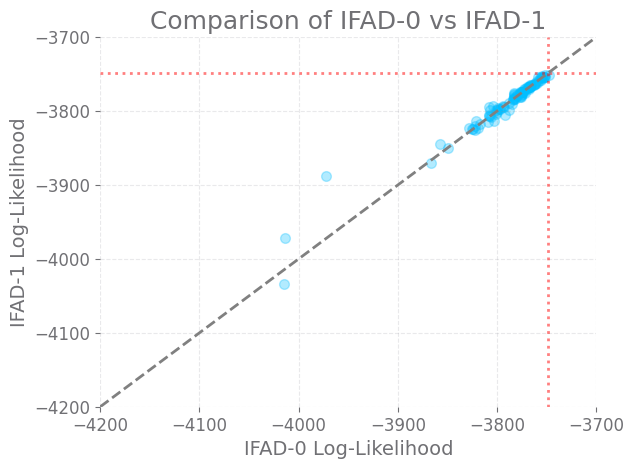

In [58]:
plt.scatter(-(np.array(gd_logliks_pf_trials)[:,-1]), -(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.3)
lo, hi = -4200, -3700
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')

plt.title('Comparison of IFAD-0 vs IFAD-1')
plt.xlabel('IFAD-0 Log-Likelihood')
plt.ylabel('IFAD-1 Log-Likelihood')

Text(0, 0.5, 'IFAD-1 Log-Likelihood')

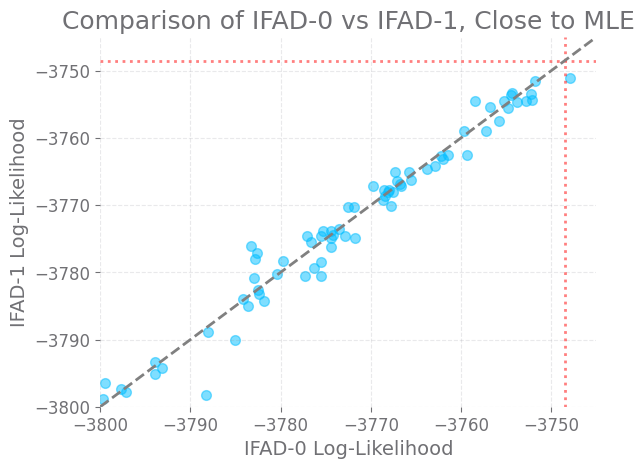

In [57]:
# DPF vs PF comparison
plt.scatter(-(np.array(gd_logliks_pf_trials)[:,-1]), -(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.5)
lo, hi = -3800, -3745
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.title('Comparison of IFAD-0 vs IFAD-1, Close to MLE')
plt.xlabel('IFAD-0 Log-Likelihood')
plt.ylabel('IFAD-1 Log-Likelihood')

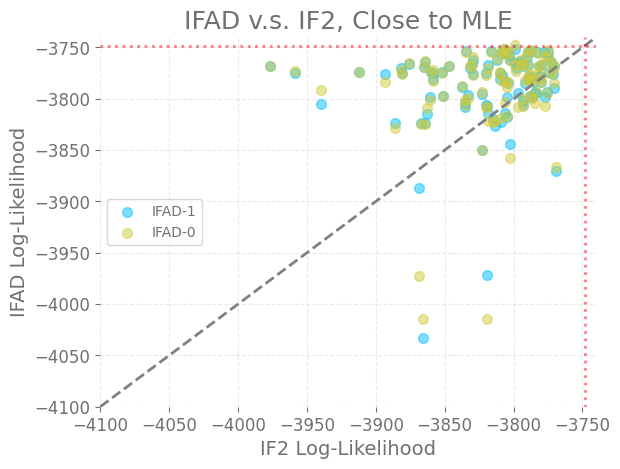

In [60]:
# Overall paired searches, our IF2
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-1')
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_pf_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-0')
lo, hi = -4100, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)

plt.title('IFAD v.s. IF2, Close to MLE')

plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('IFAD Log-Likelihood')
plt.legend()
# put horizontal and vertical lines at 3748.5

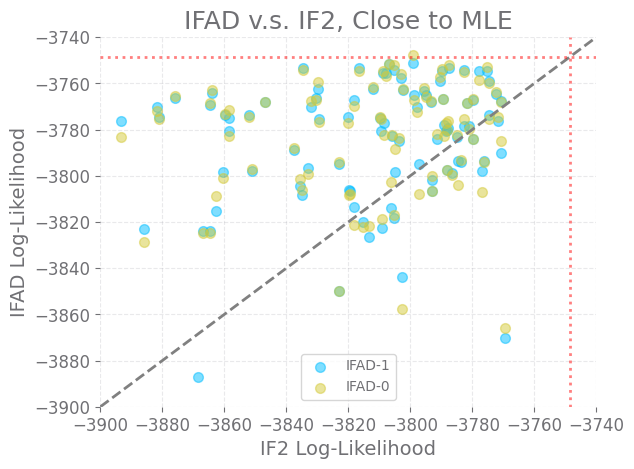

In [59]:
# Close-up paired searches, our IF2
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-1')
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_pf_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-0')
lo, hi = -3900, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)

plt.title('IFAD v.s. IF2, Close to MLE')

plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('IFAD Log-Likelihood')
plt.legend()
# put horizontal and vertical lines at 3748.5

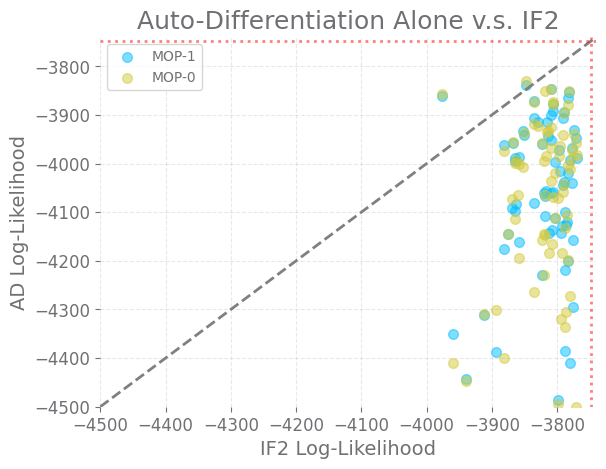

In [152]:
#Overall paired searches, our IF2
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_raw_trials)[:,-1]), marker='o', alpha=0.5,
            label='MOP-1')
plt.scatter(-(np.array(mif_logliks_trials)[:,-1]), -(np.array(gd_logliks_pf_raw_trials)[:,-1]), marker='o', alpha=0.5,
            label='MOP-0')
lo, hi = -4500, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)

plt.title('Auto-Differentiation Alone v.s. IF2')

plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('AD Log-Likelihood')
plt.legend()
# put horizontal and vertical lines at 3748.5

In [62]:
print('IF2 beats IFAD-1 this fraction of the time:', 
      np.mean(-(np.array(mif_logliks_trials)[:,-1]) > 
              -(np.array(gd_logliks_trials)[:,-1])))
print('IF2 beats IFAD-0 this fraction of the time:', 
      np.mean(-(np.array(mif_logliks_trials)[:,-1]) > 
              -(np.array(gd_logliks_pf_trials)[:,-1])))

IF2 beats IFAD-1 this fraction of the time: 0.2254902
IF2 beats IFAD-0 this fraction of the time: 0.24509805


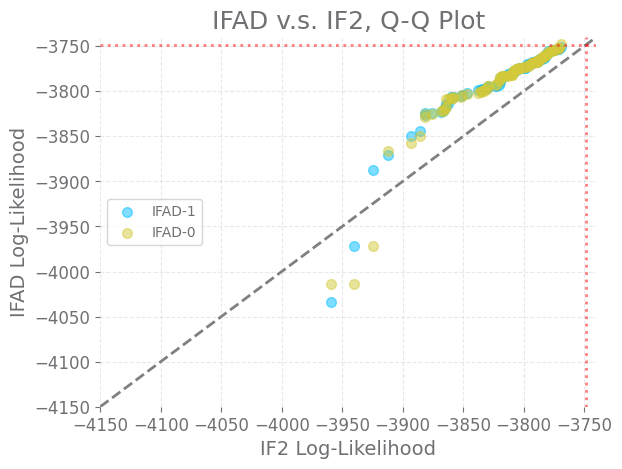

In [153]:
#QQ plot, our IF2
plt.scatter(-np.sort(np.array(mif_logliks_trials)[:,-1]), -np.sort(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-1')
plt.scatter(-np.sort(np.array(mif_logliks_trials)[:,-1]), -np.sort(np.array(gd_logliks_pf_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-0')
lo, hi = -4150, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.title('IFAD v.s. IF2, Q-Q Plot')
plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('IFAD Log-Likelihood')
plt.legend()
# put horizontal and vertical lines at 3748.5

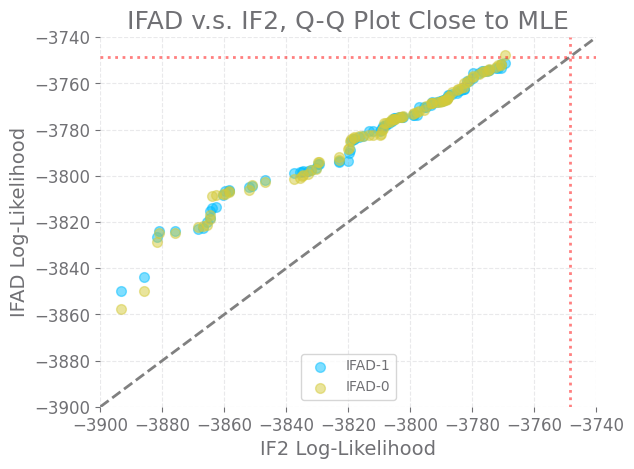

In [154]:
#QQ plot, our IF2
plt.scatter(-np.sort(np.array(mif_logliks_trials)[:,-1]), -np.sort(np.array(gd_logliks_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-1')
plt.scatter(-np.sort(np.array(mif_logliks_trials)[:,-1]), -np.sort(np.array(gd_logliks_pf_trials)[:,-1]), marker='o', alpha=0.5,
            label='IFAD-0')
lo, hi = -3900, -3740
plt.xlim(lo,hi)
plt.ylim(lo,hi)
plt.plot([lo, hi], [lo, hi], linestyle='--', color='grey')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.title('IFAD v.s. IF2, Q-Q Plot Close to MLE')
plt.xlabel('IF2 Log-Likelihood')
plt.ylabel('IFAD Log-Likelihood')
plt.legend()
# put horizontal and vertical lines at 3748.5

Text(0, 0.5, 'Count')

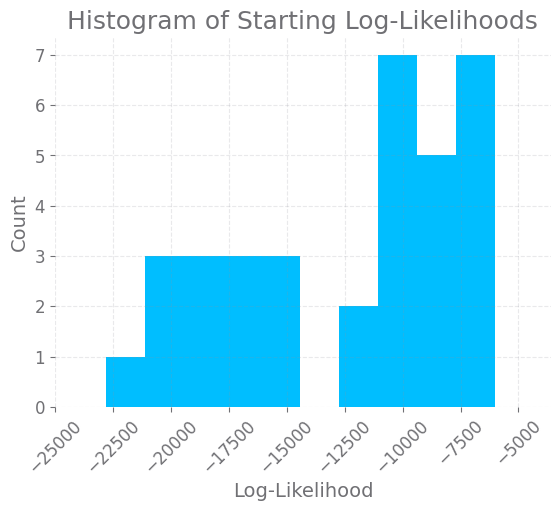

In [125]:
plt.hist(-(np.array(original_logliks)), bins=10)
plt.xlim(-25000,-3600)
plt.title('Histogram of Starting Log-Likelihoods')
plt.xticks(rotation=45)
plt.xlabel('Log-Likelihood')
plt.ylabel('Count')

In [ ]:
# 2 experiments:
# 1. Run POMP IF2 from same perturbed normal starting values, compare with ADPF
# 2. Run POMP IF2, then initialize ADPF from IF2 estimates

# Implement fitting of ivps, include in thetas

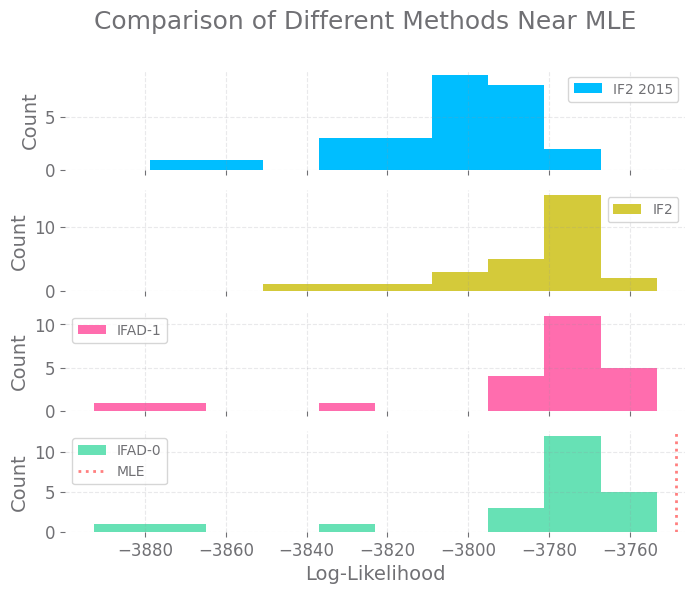

In [7]:
import seaborn as sns
import pyreadr
from scipy.special import logsumexp
plt.style.use('matplotlibrc')
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')

data = pd.DataFrame({'IF2 2015': logsumexp(result['m2.lik'], axis=0)[:34],
              'IF2': -(np.array(mif_logliks_trials)[:,-1]),
              'IFAD-1': -(np.array(gd_logliks_trials)[:,-1]),
              'IFAD-0' : -(np.array(gd_logliks_pf_trials)[:,-1]),
              'MOP-1': -(np.array(gd_logliks_raw_trials)[:,-1]),
              'MOP-0': -(np.array(gd_logliks_pf_raw_trials)[:,-1])})

data[data>-3900].iloc[:,0:4].plot.hist(subplots=True, figsize=(8,6),
                                       bins=10,
                                      xlabel='Log-Likelihood',
                                      ylabel='Count')
plt.suptitle('Comparison of Different Methods Near MLE', fontsize=18)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5, label='MLE')
plt.legend()
plt.show()

(3745.0, 4000.0)

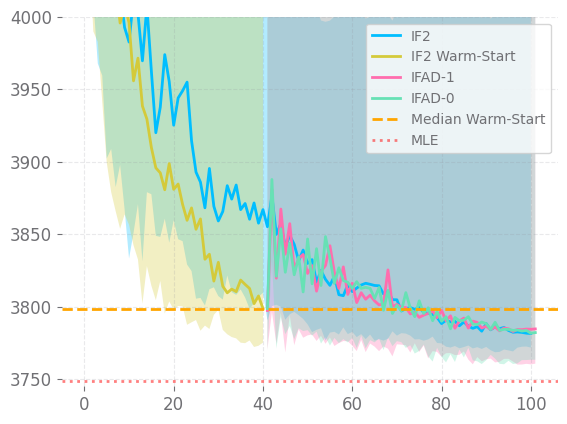

In [18]:
quantiles = [0.1,0.5,0.9]
mif_runs = pd.DataFrame(mif_logliks_trials).quantile(quantiles).T.astype(float)
mif_warm_runs = pd.DataFrame(mif_logliks_warm_trials).quantile(quantiles).T.astype(float)
gd_runs = pd.DataFrame(gd_logliks_trials).quantile(quantiles).T.astype(float)
gd_pf_runs = pd.DataFrame(gd_logliks_pf_trials).quantile(quantiles).T.astype(float)
gd_runs.index += 41
gd_pf_runs.index += 41


mif_runs[quantiles[1]].plot(label='IF2')
plt.fill_between(mif_runs.index,
                 mif_runs[quantiles[0]],
                mif_runs[quantiles[2]], alpha=0.3)
mif_warm_runs[quantiles[1]].plot(label='IF2 Warm-Start')
plt.fill_between(mif_warm_runs.index,
                 mif_warm_runs[quantiles[0]],
                mif_warm_runs[quantiles[2]], alpha=0.3)
gd_runs[quantiles[1]].plot(label='IFAD-1')
plt.fill_between(gd_runs.index,
                 gd_runs[quantiles[0]],
                gd_runs[quantiles[2]], alpha=0.3)
gd_pf_runs[quantiles[1]].plot(label='IFAD-0')
plt.fill_between(gd_runs.index,
                 gd_pf_runs[quantiles[0]],
                gd_pf_runs[quantiles[2]], alpha=0.3)
plt.axhline(np.median(np.array(mif_logliks_warm_trials), 0)[-1], 
            linestyle='dashed', color='orange', alpha=1, label='Median Warm-Start')
plt.axhline(3748.5, linestyle='dotted', color='red', alpha=0.5, label='MLE')
plt.legend()
plt.ylim(3745,4000)

(3745.0, 4000.0)

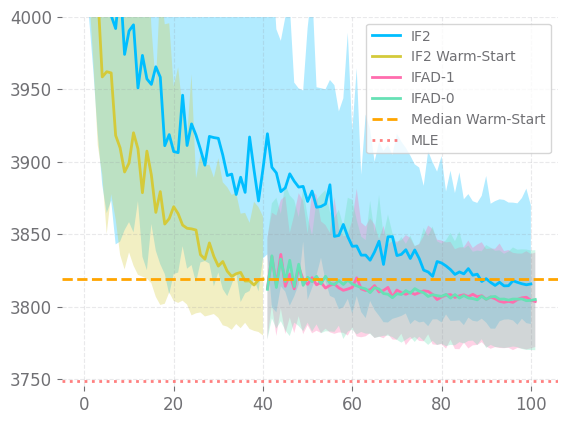

In [5]:
quantiles = [0.1,0.5,0.9]
mif_runs = pd.DataFrame(mif_logliks_trials).quantile(quantiles).T.astype(float)
mif_warm_runs = pd.DataFrame(mif_logliks_warm_trials).quantile(quantiles).T.astype(float)
gd_runs = pd.DataFrame(gd_logliks_trials).quantile(quantiles).T.astype(float)
gd_pf_runs = pd.DataFrame(gd_logliks_pf_trials).quantile(quantiles).T.astype(float)
gd_runs.index += 41
gd_pf_runs.index += 41


mif_runs[quantiles[1]].plot(label='IF2')
plt.fill_between(mif_runs.index,
                 mif_runs[quantiles[0]],
                mif_runs[quantiles[2]], alpha=0.3)
mif_warm_runs[quantiles[1]].plot(label='IF2 Warm-Start')
plt.fill_between(mif_warm_runs.index,
                 mif_warm_runs[quantiles[0]],
                mif_warm_runs[quantiles[2]], alpha=0.3)
gd_runs[quantiles[1]].plot(label='IFAD-1')
plt.fill_between(gd_runs.index,
                 gd_runs[quantiles[0]],
                gd_runs[quantiles[2]], alpha=0.3)
gd_pf_runs[quantiles[1]].plot(label='IFAD-0')
plt.fill_between(gd_runs.index,
                 gd_pf_runs[quantiles[0]],
                gd_pf_runs[quantiles[2]], alpha=0.3)
plt.axhline(np.median(np.array(mif_logliks_warm_trials), 0)[-1], 
            linestyle='dashed', color='orange', alpha=1, label='Median Warm-Start')
plt.axhline(3748.5, linestyle='dotted', color='red', alpha=0.5, label='MLE')
plt.legend()
plt.ylim(3745,4000)

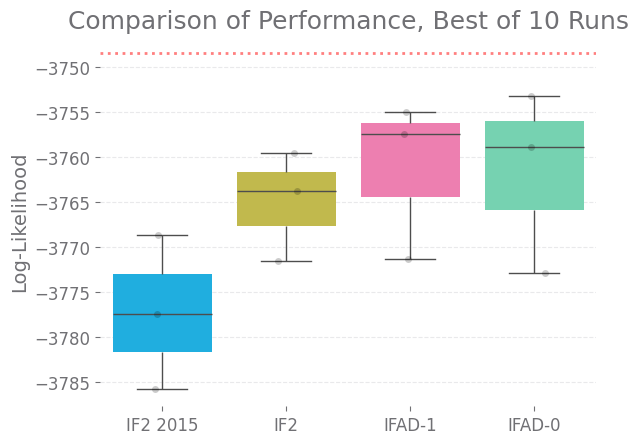

In [20]:

import pyreadr
from scipy.special import logsumexp
import seaborn as sns
plt.style.use('matplotlibrc')
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
ax = sns.boxplot(data.rolling(10).max().iloc[9:, :4][::10],
                showfliers = False)
sns.stripplot(data.rolling(10).max().iloc[9:, :4][::10],
             alpha=0.2, color='black')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylabel('Log-Likelihood')
plt.title('Comparison of Performance, Best of 10 Runs')
plt.show()

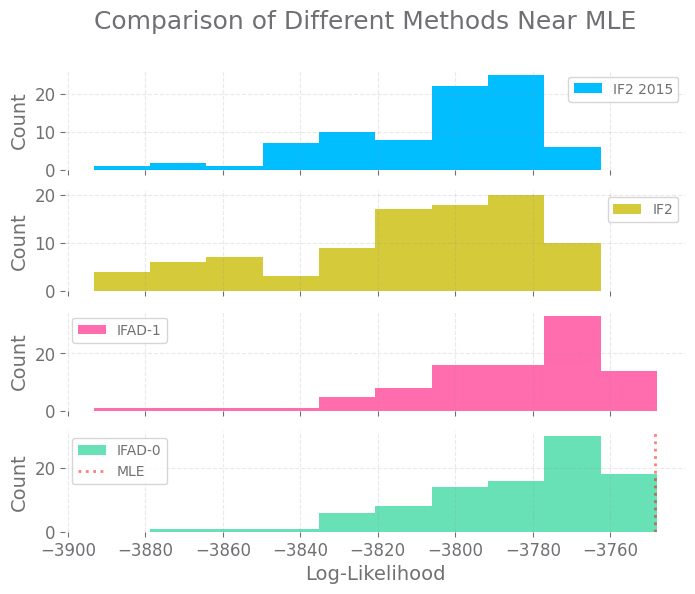

In [224]:
import seaborn as sns
import pyreadr
from scipy.special import logsumexp
plt.style.use('matplotlibrc')
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')

data = pd.DataFrame({'IF2 2015': logsumexp(result['m2.lik'], axis=0),
              'IF2': -(np.array(mif_logliks_trials)[:-2,-1]),
              'IFAD-1': -(np.array(gd_logliks_trials)[:-2,-1]),
              'IFAD-0' : -(np.array(gd_logliks_pf_trials)[:-2,-1]),
              'MOP-1': -(np.array(gd_logliks_raw_trials)[:-2,-1]),
              'MOP-0': -(np.array(gd_logliks_pf_raw_trials)[:-2,-1])})

data[data>-3900].iloc[:,0:4].plot.hist(subplots=True, figsize=(8,6),
                                       bins=10,
                                      xlabel='Log-Likelihood',
                                      ylabel='Count')
plt.suptitle('Comparison of Different Methods Near MLE', fontsize=18)
plt.axvline(-3748.5, linestyle='dotted', color='r', alpha=0.5, label='MLE')
plt.legend()
plt.show()

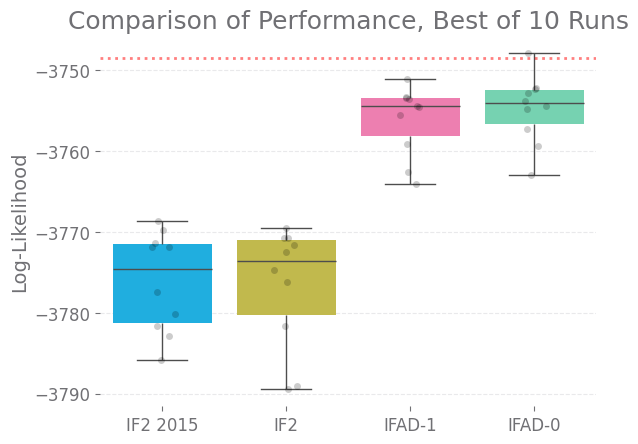

In [155]:

import pyreadr
from scipy.special import logsumexp
import seaborn as sns
plt.style.use('matplotlibrc')
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
ax = sns.boxplot(data.rolling(10).max().iloc[9:, :4][::10],
                showfliers = False)
sns.stripplot(data.rolling(10).max().iloc[9:, :4][::10],
             alpha=0.2, color='black')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylabel('Log-Likelihood')
plt.title('Comparison of Performance, Best of 10 Runs')
plt.show()

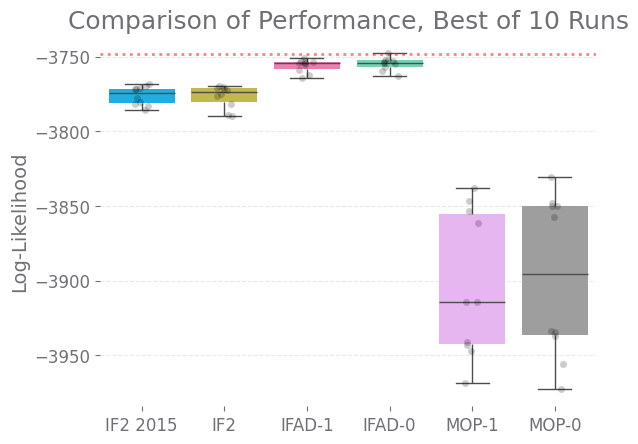

In [151]:

import pyreadr
from scipy.special import logsumexp
import seaborn as sns
plt.style.use('matplotlibrc')
result = pyreadr.read_r('data/dacca/cholera-mif1-mif2.rda')
ax = sns.boxplot(data.rolling(10).max().iloc[9:][::10],
                showfliers = False)
sns.stripplot(data.rolling(10).max().iloc[9:][::10],
             alpha=0.2, color='black')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylabel('Log-Likelihood')
plt.title('Comparison of Performance, Best of 10 Runs')
plt.show()

In [ ]:
ax = sns.boxplot(data.iloc[:,:4],
                showfliers = False)
sns.stripplot(data.iloc[:,:4],
             alpha=0.2, color='black')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylim(-4200, -3745)
plt.ylabel('Log-Likelihood')
plt.title('Comparison of Performance')
plt.show()

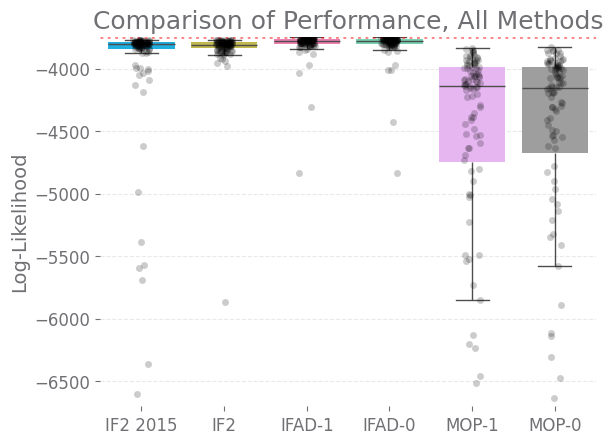

In [130]:
ax = sns.boxplot(data,
                showfliers = False)
sns.stripplot(data,
             alpha=0.2, color='black')
plt.axhline(-3748.5, linestyle='dotted', color='r', alpha=0.5)
plt.ylim(-6700, -3745)
plt.ylabel('Log-Likelihood')
plt.title('Comparison of Performance, All Methods')
plt.show()

In [ ]:
# autodiff is central to many scientific applications and advances
# it has not made its way to POMPs and the particle filter 
# recently it has been shown that black-box libraries can differentiate through PF with a small tweak,
#    and that this corresponds to the REINFORCE estimator from Poyiadjis
# previously success has been limited in applying this to real-world problems, 
#    especially ones that need the plug-and-play property
# we create a smooth extension to the particle filter, by formally constructing a derivative,
#    by constructing a properly-weighted off-policy extension of the particle filter
#        with differentiable weights, and show that when evaluating on-policy,
#        DPF coincides with an estimator of the unique derivative under the seed
# we show consistency and concentration of the Poyiadjis estimator,
#    as well as provide a rate of convergence of the optimization procedure using it.
# while we use the Poyiadjis estimator and SW procedure to obtain it in practice,
#    they didn't have the theory or details of a successful optimization implementation
# we therefore leverage DPF to algorithmically implement this
#    algorithmically, a key ingredient to it working well is the gradient norm
#    we demonstrate that this works well on interesting problems
#    and show that we only need 20 epochs and not the 500 they use
# we show that we only need a simulator to implement this
# we formally show that DPF is equivalent to the derivative
# we show that this can be thought of as an analogue to mini-batch GD
# we show that GPU speedups enable trivial parallelization and fast computation

# provide pseudocode for actual practical algorithm and theoretical algorithm

In [255]:
quantiles = [0.1,0.5,0.9]
mif_runs = pd.DataFrame(mif_logliks_trials).quantile(quantiles).T
mif_warm_runs = pd.DataFrame(mif_logliks_warm_trials).quantile(quantiles).T
gd_runs = pd.DataFrame(gd_logliks_trials).quantile(quantiles).T
gd_pf_runs = pd.DataFrame(gd_logliks_pf_trials).quantile(quantiles).T
gd_runs.index += 41
gd_pf_runs.index += 41

(array([ 1.,  1.,  1.,  1.,  6.,  8., 15., 13., 31., 21.]),
 array([-3887.33911133, -3873.71435547, -3860.08935547, -3846.46435547,
        -3832.83959961, -3819.21484375, -3805.58984375, -3791.96484375,
        -3778.34008789, -3764.71533203, -3751.09033203]),
 <BarContainer object of 10 artists>)

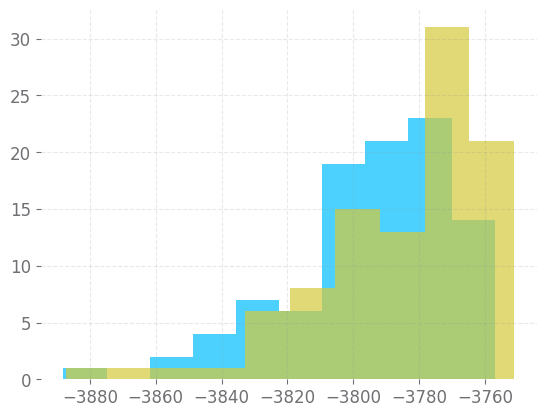

In [233]:
plt.hist(-mif_logliks_warm_trials[:,-1][-mif_logliks_warm_trials[:,-1]>-3900], alpha=0.7)
plt.hist(-gd_logliks_trials[:,-1][-gd_logliks_trials[:,-1]>-3900], alpha=0.7)

In [243]:
np.median(mif_logliks_warm_trials, 0)[-1]

Array(3791.0342, dtype=float32)

In [252]:
gd_runs.index+40

RangeIndex(start=40, stop=101, step=1)

(3745.0, 4000.0)

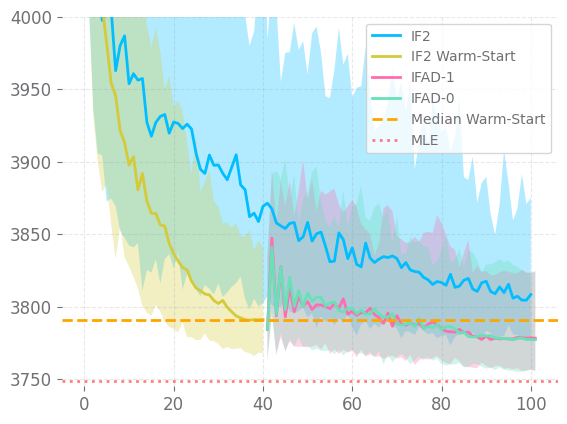

In [265]:
quantiles = [0.1,0.5,0.9]
mif_runs = pd.DataFrame(mif_logliks_trials).quantile(quantiles).T
mif_warm_runs = pd.DataFrame(mif_logliks_warm_trials).quantile(quantiles).T
gd_runs = pd.DataFrame(gd_logliks_trials).quantile(quantiles).T
gd_pf_runs = pd.DataFrame(gd_logliks_pf_trials).quantile(quantiles).T
gd_runs.index += 41
gd_pf_runs.index += 41


mif_runs[quantiles[1]].plot(label='IF2')
plt.fill_between(mif_runs.index,
                 mif_runs[quantiles[0]],
                mif_runs[quantiles[2]], alpha=0.3)
mif_warm_runs[quantiles[1]].plot(label='IF2 Warm-Start')
plt.fill_between(mif_warm_runs.index,
                 mif_warm_runs[quantiles[0]],
                mif_warm_runs[quantiles[2]], alpha=0.3)
gd_runs[quantiles[1]].plot(label='IFAD-1')
plt.fill_between(gd_runs.index,
                 gd_runs[quantiles[0]],
                gd_runs[quantiles[2]], alpha=0.3)
gd_pf_runs[quantiles[1]].plot(label='IFAD-0')
plt.fill_between(gd_runs.index,
                 gd_pf_runs[quantiles[0]],
                gd_pf_runs[quantiles[2]], alpha=0.3)
plt.axhline(np.median(mif_logliks_warm_trials, 0)[-1], 
            linestyle='dashed', color='orange', alpha=1, label='Median Warm-Start')
plt.axhline(3748.5, linestyle='dotted', color='red', alpha=0.5, label='MLE')
plt.legend()
plt.ylim(3745,4000)

In [ ]:
mif_logliks_trials = np.vstack([np.load('outs/mif_logliks_trials.npy'),
                               np.load('outs/mif_logliks_trials-1.npy'),
                               np.load('outs/mif_logliks_trials-2.npy')])

mif_logliks_warm_trials = np.vstack([np.load('outs/mif_logliks_warm_trials.npy'),
                                    np.load('outs/mif_logliks_warm_trials-1.npy'),
                                    np.load('outs/mif_logliks_warm_trials-2.npy')])

gd_logliks_trials = np.vstack([np.load('outs/gd_logliks_trials.npy'),
                              np.load('outs/gd_logliks_trials-1.npy'),
                              np.load('outs/gd_logliks_trials-2.npy')])

gd_logliks_pf_trials = np.vstack([np.load('outs/gd_logliks_pf_trials.npy'),
                                 np.load('outs/gd_logliks_pf_trials-1.npy'),
                                 np.load('outs/gd_logliks_pf_trials-2.npy')])

gd_logliks_raw_trials = np.vstack([np.load('outs/gd_logliks_raw_trials.npy'),
                                  np.load('outs/gd_logliks_raw_trials-1.npy'),
                                  np.load('outs/gd_logliks_raw_trials-2.npy')])

gd_logliks_pf_raw_trials = np.vstack([np.load('outs/gd_logliks_pf_raw_trials.npy'),
                                     np.load('outs/gd_logliks_pf_raw_trials-1.npy'),
                                     np.load('outs/gd_logliks_pf_raw_trials-2.npy')])

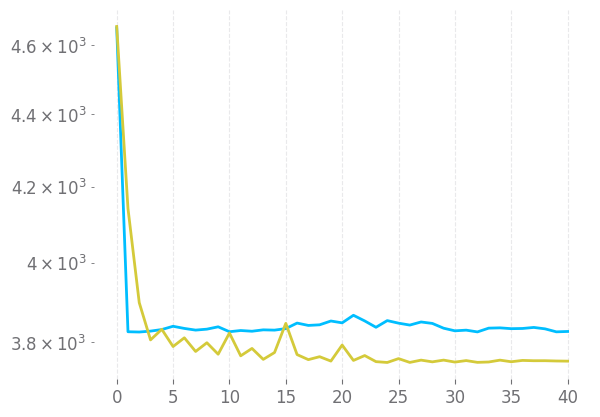

In [190]:
plt.plot(mif_logliks)
plt.plot(gd_logliks)
plt.yscale('log')
#plt.plot(bfgs_logliks)